# Post-processing for 2030StateScenario


## Packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import pickle

import nygrid.run_nygrid as ng_run
import nygrid.nygrid as ng_grid
import nygrid.postprocessing as ng_post

In [2]:
# Set up directories
cwd = os.getcwd()
if 'examples' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

fig_dir = os.path.join(os.path.dirname(data_dir), 'figures')
print('Figure directory: {}'.format(fig_dir))

results_dir = os.path.join(os.path.dirname(data_dir), 'results')
print('Results directory: {}'.format(results_dir))


Figure directory: /mnt/Bo_HDD/NYgrid-python/figures
Results directory: /mnt/Bo_HDD/NYgrid-python/results


## Read grid data

In [3]:
# Cost modifiers
ext_cost_factor = 0.0
# fo_cost_factor = 1.0
fo_cost_factor = 0.5

# Simulation time settings
valid_days = 14
lookahead_days = 2

valid_hours = 24 * valid_days
lookahead_hours = 24 * lookahead_days

sim_start_time = datetime(2018, 1, 1, 0, 0, 0)
sim_end_time = datetime(2018, 12, 31, 23, 0, 0)
timestamp_list = pd.date_range(sim_start_time, sim_end_time, freq=f'{valid_days}D')


## Read OPF results

In [4]:
sim_name = f'2030StateScenario_NoCHPE_ext{ext_cost_factor}_fo{fo_cost_factor}_daily'

grid_data_dir_2030 = os.path.join(data_dir, 'grid', '2030StateScenario_NoCHPE')
assert os.path.exists(
    grid_data_dir_2030), f'Grid data directory not found: {grid_data_dir_2030}'

sim_results_dir_2030 = os.path.join(results_dir, sim_name)
assert os.path.exists(
    sim_results_dir_2030), f'Results directory not found: {sim_results_dir_2030}'

# Read load and generation profiles
grid_prop_2030 = ng_run.read_grid_prop(grid_data_dir_2030,
                                       if_lims_prop_file='if_lims_prop_2030StateScenario.csv',
                                       esr_prop_file='esr_prop_2030StateScenario.csv',
                                       dcline_prop_file='dcline_prop_2030StateScenario.csv')
display(grid_prop_2030.keys())

grid_profile_2030 = ng_run.read_grid_profile(grid_data_dir_2030, year=2030)
display(grid_profile_2030.keys())

# Generator fuel types
display(grid_prop_2030['gen_fuel']['GEN_FUEL'].unique())

# Create NYGrid object
start_datetime_0 = timestamp_list[0]
end_datetime_0 = start_datetime_0 + timedelta(hours=23)
nygrid_sim_2030 = ng_grid.NYGrid(grid_prop=grid_prop_2030,
                                 start_datetime=start_datetime_0,
                                 end_datetime=end_datetime_0,
                                 verbose=False)
print(f"Number of generators: {nygrid_sim_2030.NG}")
print(f"Number of HVDC lines: {nygrid_sim_2030.NDCL}")
print(f"Number of VRE generators: {nygrid_sim_2030.NVRE}")
print(f"Number of ESR units: {nygrid_sim_2030.NESR}")
print(
    f"Number of buses and branches: {nygrid_sim_2030.NB} and {nygrid_sim_2030.NBR}")
print(f"Number of loads: {nygrid_sim_2030.NL}")
print(f"Number of time periods: {nygrid_sim_2030.NT}")

dict_keys(['bus_prop', 'gen_prop', 'gen_fuel', 'gencost_prop', 'branch_prop', 'if_lim_prop', 'if_map_prop', 'esr_prop', 'dcline_prop'])

dict_keys(['load_profile', 'genmax_profile', 'genmin_profile', 'gencost0_profile', 'gencost1_profile', 'gencost_startup_profile'])

array(['CT_NG', 'CC_NG', 'CT_FO2', 'CT_KER', 'ST_NG', 'ST_FO6', 'NU_UR',
       'HY_WAT', 'Import_Import', 'WT_WND', 'PV_SUN', 'Other_Other',
       'Load_Load'], dtype=object)

Number of generators: 470
Number of HVDC lines: 6
Number of VRE generators: 0
Number of ESR units: 40
Number of buses and branches: 57 and 97
Number of loads: 57
Number of time periods: 24


In [5]:
# Loop through all days
results_list_2030 = []

for d in range(len(timestamp_list)):
    
    # Set clycle start and end datetime
    cycle_start_time = timestamp_list[d]

    # Read results
    filename = f'nygrid_sim_{sim_name}_{cycle_start_time.strftime("%Y%m%d")}_{valid_days}_{lookahead_days}.pkl'
    with open(os.path.join(sim_results_dir_2030, filename), 'rb') as f:
        results = pickle.load(f)

    results_list_2030.append(results)

In [6]:
# Power dispatch of generators by fuel type
# Including ESR, DC line, and VRE
pg_by_fuel_dict_2030 = ng_post.get_pg_by_fuel_from_list(results_list_2030, 
                                                        nygrid_sim_2030,
                                                        valid_hours=valid_hours)

# ESR results, including discharge and charge power, and SOC
esr_results_2030 = ng_post.get_esr_results_from_list(results_list_2030, 
                                                     nygrid_sim_2030,
                                                     valid_hours=valid_hours)

# LMP by bus and by zone
# lmp_results_2018 = ng_post.get_lmp_results_from_list(results_list_2018, 
#                                                      nygrid_sim_2018,
#                                                      valid_hours=24)

# Branch flow and interface flow results
flow_results_2030 = ng_post.get_flow_results_from_list(results_list_2030, 
                                                       nygrid_sim_2030,
                                                       valid_hours=valid_hours)

# Costs
cost_results_2030 = ng_post.get_cost_results_from_list(results_list_2030, 
                                                       nygrid_sim_2030,
                                                       valid_hours=valid_hours)

# Slack variables and penalty costs
slack_results_2030 = ng_post.get_slack_results_from_list(results_list_2030, 
                                                         nygrid_sim_2030,
                                                         valid_hours=valid_hours)

## Calculate heat input

In [7]:
# 2018 NYCA: 181 thermal generators
thermal_params_2030 = pd.read_csv(os.path.join(
    grid_data_dir_2030, 'thermal_params.csv'))
thermal_params_2030['GEN_NAME'] = thermal_params_2030['NYISO_Name']+thermal_params_2030['ID']

In [8]:
# Save thermal generation profiles for emissions calculation
thermal_fuel_types = ['CC_NG', 'CT_NG', 'CT_FO2', 'CT_KER', 'ST_NG', 'ST_FO6']
thermal_pg_list_2030 = [pg_by_fuel_dict_2030[fuel] for fuel in thermal_fuel_types]
thermal_pg_2030StateScenario = pd.concat(thermal_pg_list_2030, axis=1)
thermal_pg_2030StateScenario = thermal_pg_2030StateScenario.sort_index(axis=1)

# Order the columns
thermal_pg_2030StateScenario = thermal_pg_2030StateScenario[thermal_params_2030['GEN_NAME']]

# Save to csv
thermal_pg_2030StateScenario.to_csv(os.path.join(results_dir, sim_name,
                                            f'thermal_pg_{sim_name}.csv'))

# Calculate heat input from power generation
heat_input_2030StateScenario = ng_post.thermal_pg_2_heat_input(thermal_pg_2030StateScenario, 
                                                          thermal_params_2030)

# Order the columns
heat_input_2030StateScenario = heat_input_2030StateScenario[thermal_params_2030['GEN_NAME']]

# Save to csv
heat_input_2030StateScenario.to_csv(os.path.join(results_dir, sim_name,
                                            f'heat_input_{sim_name}.csv'))

In [9]:
# Create a dictionary for generator to bus mapping
gen_2bus = grid_prop_2030['gen_prop'][['GEN_NAME','GEN_BUS']].copy()
gen_2bus['GEN_BUS'] = gen_2bus['GEN_BUS'].astype(int)
gen_2bus_dict = dict(zip(gen_2bus['GEN_NAME'], gen_2bus['GEN_BUS']))

# Large load time series
large_load = pg_by_fuel_dict_2030['Load_Load']
large_load_2bus = large_load.copy().T.groupby(gen_2bus_dict).sum().T
# Convert negative generation to positive load
large_load_2bus = -large_load_2bus

# Add large load to load profile
load_profile_2030StateScenario = grid_profile_2030['load_profile'].copy()
load_profile_2030StateScenario = load_profile_2030StateScenario.add(large_load_2bus, fill_value=0)

# Save load profile for emissions calculation
load_profile_2030StateScenario.to_csv(os.path.join(results_dir, sim_name,
                                              f'load_profile_{sim_name}.csv'))

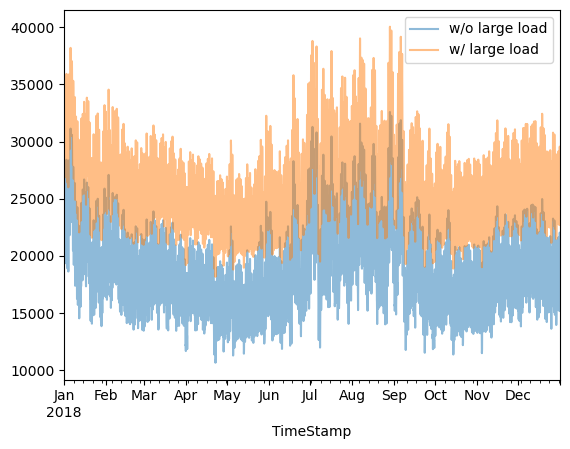

In [10]:
grid_profile_2030['load_profile'].sum(axis=1).plot(label='w/o large load', alpha=0.5)
load_profile_2030StateScenario.sum(axis=1).plot(label='w/ large load', alpha=0.5)
plt.legend()

## Plotting

In [11]:
if not os.path.exists(os.path.join(fig_dir, 'thermal_pg')):
    os.makedirs(os.path.join(fig_dir, 'thermal_pg'))


In [12]:
# Representative weeks
season_list = ['Winter', 'Spring', 'Summer', 'Autumn']

winter_week = ['2018-01-01', '2018-01-07']
spring_week = ['2018-04-02', '2018-04-08']
summer_week = ['2018-07-02', '2018-07-08']
autumn_week = ['2018-10-01', '2018-10-07']

week_list = [winter_week, spring_week, summer_week, autumn_week]

### 1. Power generation by fuel type

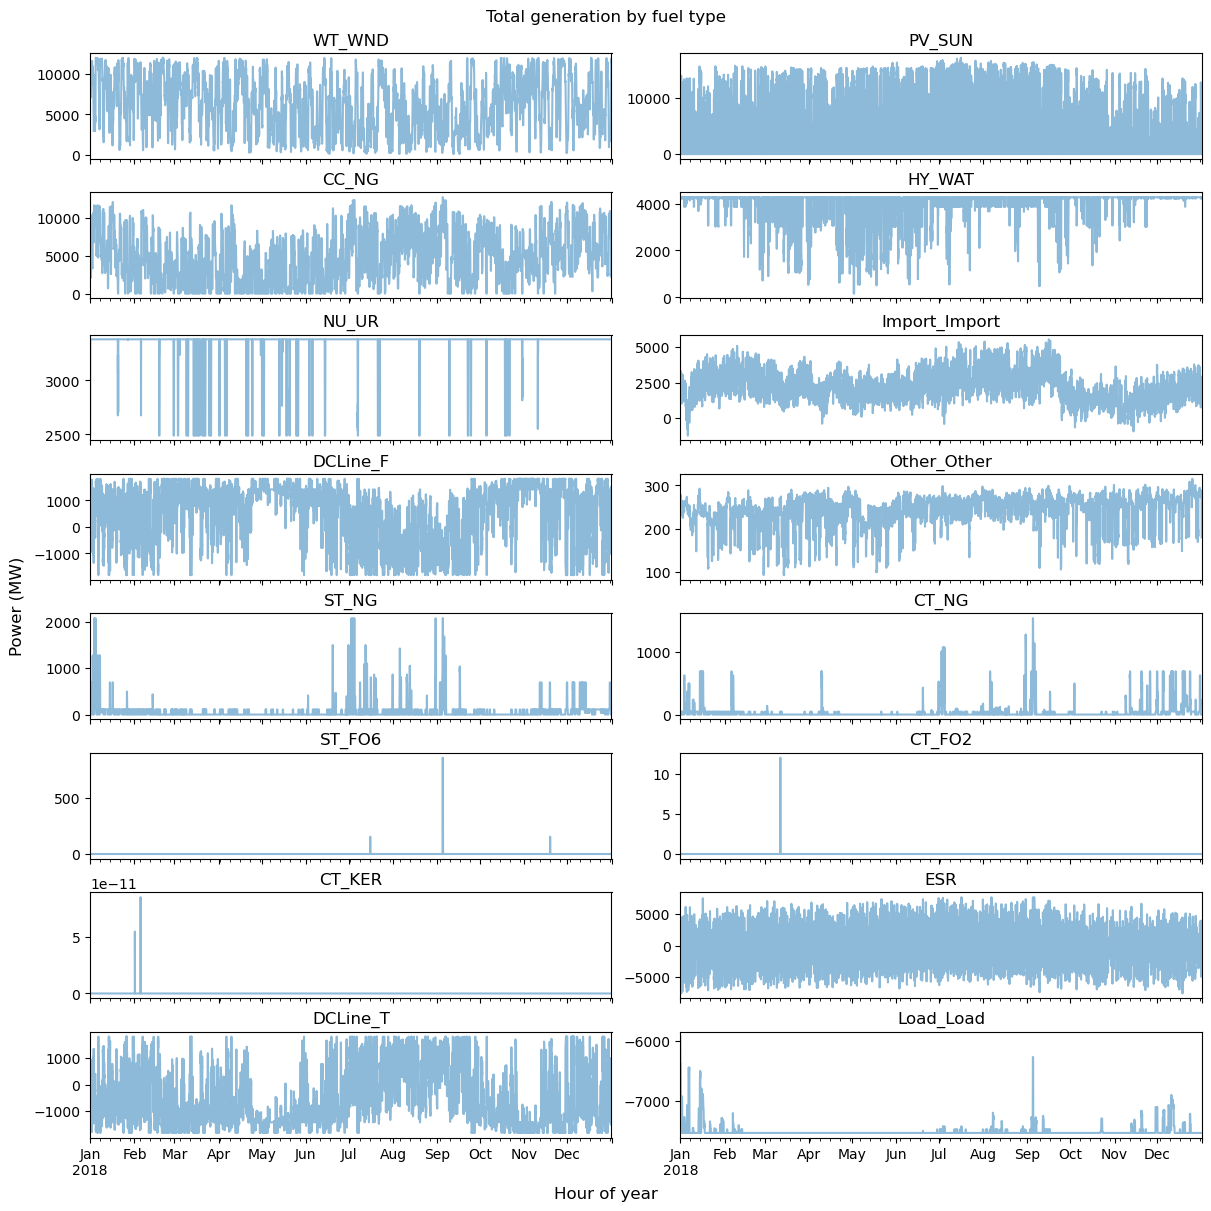

In [13]:
fig, axs = plt.subplots(len(pg_by_fuel_dict_2030)//2, 2, figsize=(12, 12),
                        layout='constrained', sharex=True)

# 2018 Baseline
pg_by_fuel_sum_2030 = dict()

for fuel_type, pg_by_fuel in pg_by_fuel_dict_2030.items():
    pg_by_fuel_sum_2030[fuel_type] = pg_by_fuel.sum(axis=1)

# Convert to DataFrame
pg_by_fuel_sum_2030 = pd.DataFrame(pg_by_fuel_sum_2030,
                                   index=pg_by_fuel_dict_2030['CC_NG'].index)

# Sort fuel types by total generation
pg_by_fuel_sum_2030 = pg_by_fuel_sum_2030.reindex(
    pg_by_fuel_sum_2030.sum().sort_values(ascending=False).index, axis=1)

for i, fuel_type in enumerate(pg_by_fuel_sum_2030.columns):
    ax = axs.flatten()[i]
    pg_by_fuel_sum_2030[fuel_type].plot(ax=ax, alpha=0.5, color='tab:blue')
    
    ax.set_title(fuel_type)

fig.supxlabel('Hour of year')
fig.supylabel('Power (MW)')
fig.suptitle('Total generation by fuel type')
plt.show()

### Check renewable curtailment

In [14]:
gen2zone_dict = grid_prop_2030['gen_prop'].set_index('GEN_NAME')['GEN_ZONE'].to_dict()

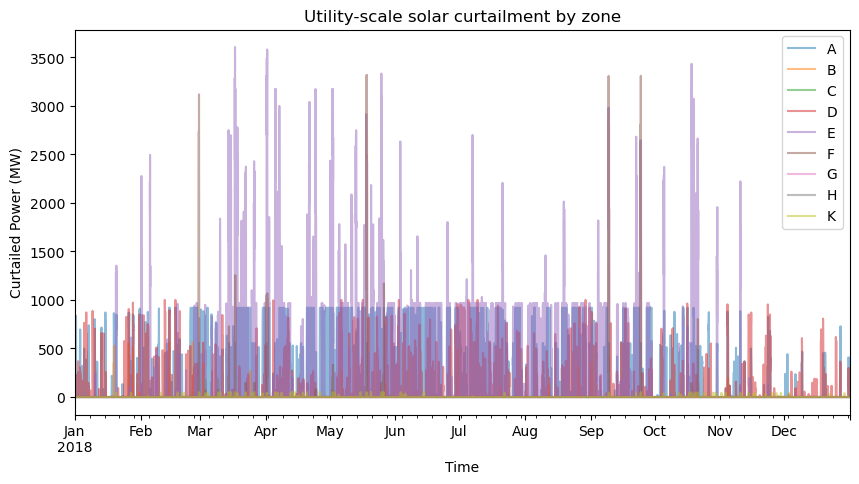

In [15]:
## UPV curtailment
# Maximum available UPV generation
upv_index = grid_prop_2030["gen_fuel"]["GEN_FUEL"].isin(
    ["PV_SUN"]).to_numpy()
upv_genmax_profile = grid_profile_2030['genmax_profile'].loc[:, upv_index]

# Calculate UPV curtailment
upv_curtailment = upv_genmax_profile - pg_by_fuel_dict_2030['PV_SUN']

# Aggregate UPV curtailment by zone
upv_curtailment_zone = upv_curtailment.groupby(
    [gen2zone_dict], axis=1).sum()

# Plot UPV curtailment
upv_curtailment_zone.plot(legend=True, alpha=0.5, figsize=(10, 5))
plt.xlabel('Time')
plt.ylabel('Curtailed Power (MW)')
plt.title('Utility-scale solar curtailment by zone')
plt.show()

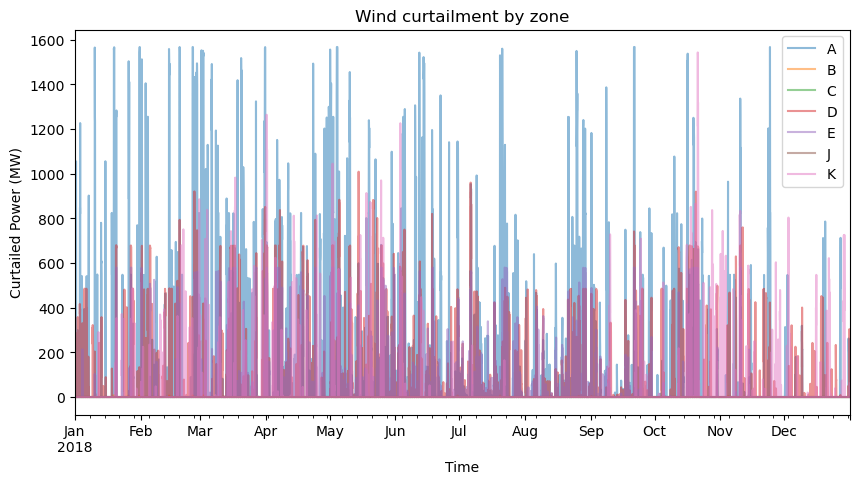

In [16]:
## Wind curtailment
wind_index = grid_prop_2030["gen_fuel"]["GEN_FUEL"].isin(
    ["WT_WND"]).to_numpy()
wind_genmax_profile = grid_profile_2030['genmax_profile'].loc[:, wind_index]

# Calculate UPV curtailment
wind_curtailment = wind_genmax_profile - pg_by_fuel_dict_2030['WT_WND']

# Aggregate by zone
wind_curtailment_zone = wind_curtailment.T.groupby(gen2zone_dict).sum().T

# Plot UPV curtailment
wind_curtailment_zone.plot(legend=True, alpha=0.5, figsize=(10, 5))
plt.xlabel('Time')
plt.ylabel('Curtailed Power (MW)')
plt.title('Wind curtailment by zone')
plt.show()

### Check external generation and load

In [17]:
# External bus load profile
bus_prop = nygrid_sim_2030.grid_prop['bus_prop']
bus_zone_dict = bus_prop.set_index('BUS_I')['BUS_ZONE'].to_dict()
load_profile_by_zone_2018 = load_profile_2030StateScenario.groupby(bus_zone_dict, axis=1).sum()

load_profile_external = load_profile_by_zone_2018[['NE','PJM','IESO']]
load_profile_external_sum = load_profile_external.sum(axis=1)

In [18]:
# External generator maximum generation profile
genmax_profile = grid_profile_2030['genmax_profile']

ne_cols = [col for col in genmax_profile.columns if 'NE' in col]
pjm_cols = [col for col in genmax_profile.columns if 'PJM' in col]
ieso_cols = [col for col in genmax_profile.columns if 'IESO' in col]
genmax_ne_sum = genmax_profile[ne_cols].sum(axis=1)
genmax_pjm_sum = genmax_profile[pjm_cols].sum(axis=1)
genmax_ieso_sum = genmax_profile[ieso_cols].sum(axis=1)

genmax_profile_external_sum = genmax_ne_sum + genmax_pjm_sum + genmax_ieso_sum

In [19]:
# External generator minimum generation profile
genmin_profile = grid_profile_2030['genmin_profile']

ne_cols = [col for col in genmin_profile.columns if 'NE' in col]
pjm_cols = [col for col in genmin_profile.columns if 'PJM' in col]
ieso_cols = [col for col in genmin_profile.columns if 'IESO' in col]
genmin_ne_sum = genmin_profile[ne_cols].sum(axis=1)
genmin_pjm_sum = genmin_profile[pjm_cols].sum(axis=1)
genmin_ieso_sum = genmin_profile[ieso_cols].sum(axis=1)

genmin_profile_external_sum = genmin_ne_sum + genmin_pjm_sum + genmin_ieso_sum

In [20]:
# External generation profile
pg_external = pg_by_fuel_dict_2030['Import_Import']
ne_cols = [col for col in pg_external.columns if 'NE' in col]
pjm_cols = [col for col in pg_external.columns if 'PJM' in col]
ieso_cols = [col for col in pg_external.columns if 'IESO' in col]
pg_ne_sum = pg_external[ne_cols].sum(axis=1)
pg_pjm_sum = pg_external[pjm_cols].sum(axis=1)
pg_ieso_sum = pg_external[ieso_cols].sum(axis=1)
pg_external_sum = pg_ne_sum + pg_pjm_sum + pg_ieso_sum

In [21]:
# External net generation profile
net_pg_ne_sum = pg_ne_sum - load_profile_external['NE']
net_pg_pjm_sum = pg_pjm_sum - load_profile_external['PJM']
net_pg_ieso_sum = pg_ieso_sum - load_profile_external['IESO']
net_pg_external_sum = net_pg_ne_sum + net_pg_pjm_sum + net_pg_ieso_sum

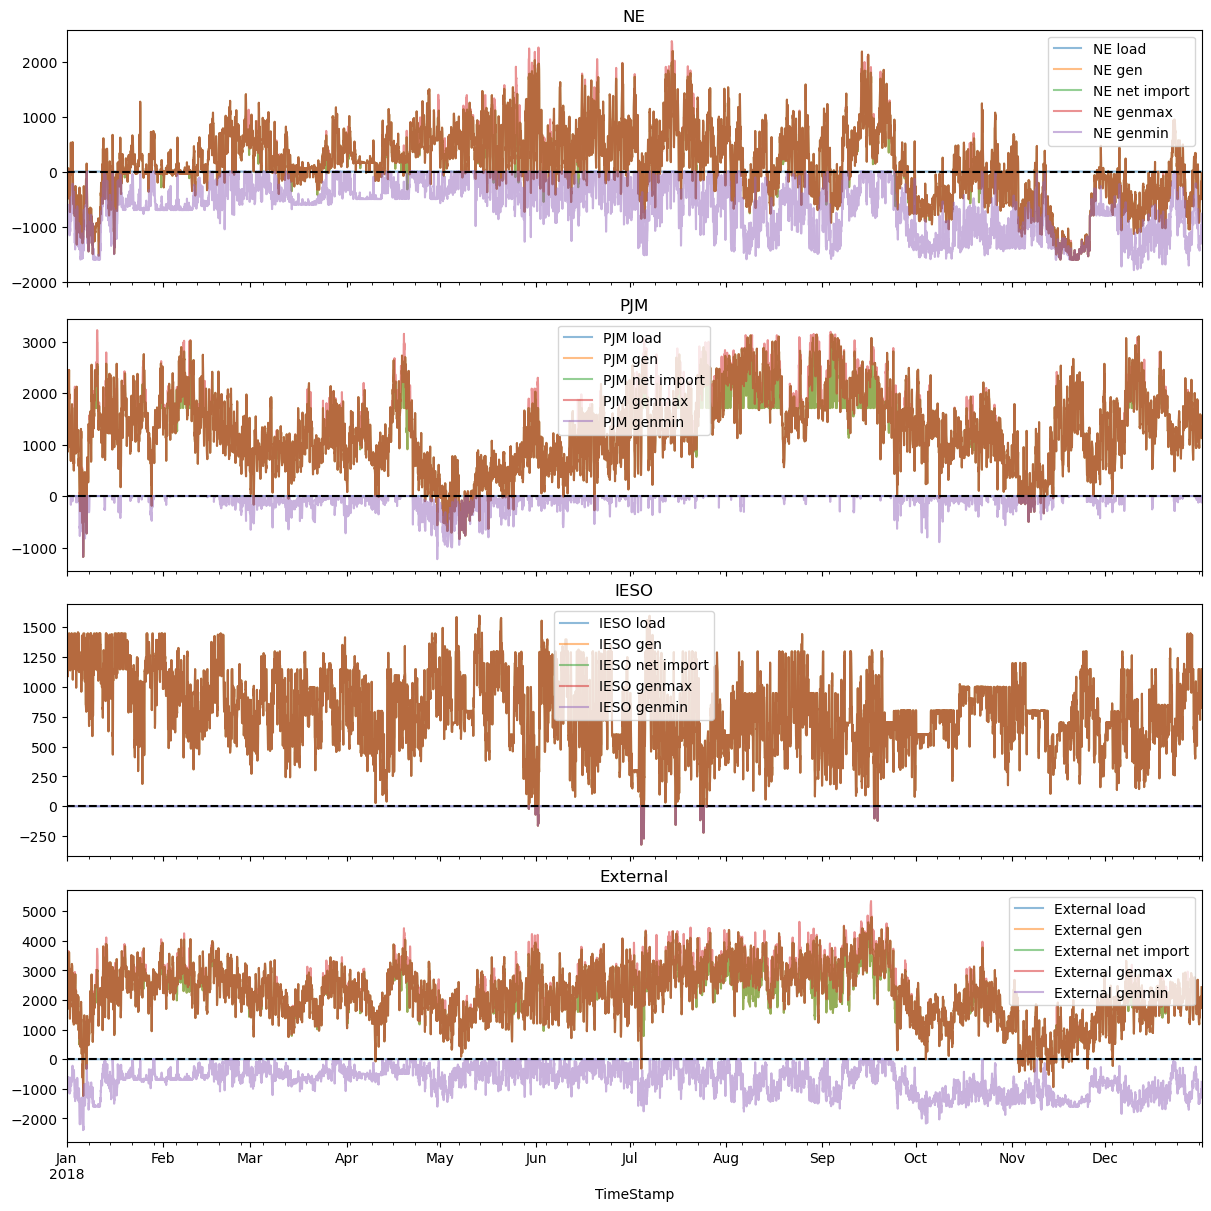

In [22]:
fig, axs = plt.subplots(4, 1,figsize=(12, 12), layout='constrained', sharex=True)

load_profile_external['NE'].plot(ax=axs[0], label='NE load', alpha=0.5)
pg_ne_sum.plot(ax=axs[0], label='NE gen', alpha=0.5)
net_pg_ne_sum.plot(ax=axs[0], label='NE net import', alpha=0.5)
genmax_ne_sum.plot(ax=axs[0], label='NE genmax', alpha=0.5)
genmin_ne_sum.plot(ax=axs[0], label='NE genmin', alpha=0.5)
axs[0].set_title('NE')

load_profile_external['PJM'].plot(ax=axs[1], label='PJM load', alpha=0.5)
pg_pjm_sum.plot(ax=axs[1], label='PJM gen', alpha=0.5)
net_pg_pjm_sum.plot(ax=axs[1], label='PJM net import', alpha=0.5)
genmax_pjm_sum.plot(ax=axs[1], label='PJM genmax', alpha=0.5)
genmin_pjm_sum.plot(ax=axs[1], label='PJM genmin', alpha=0.5)
axs[1].set_title('PJM')

load_profile_external['IESO'].plot(ax=axs[2], label='IESO load', alpha=0.5)
pg_ieso_sum.plot(ax=axs[2], label='IESO gen', alpha=0.5)
net_pg_ieso_sum.plot(ax=axs[2], label='IESO net import', alpha=0.5)
genmax_ieso_sum.plot(ax=axs[2], label='IESO genmax', alpha=0.5)
genmin_ieso_sum.plot(ax=axs[2], label='IESO genmin', alpha=0.5)
axs[2].set_title('IESO')

load_profile_external_sum.plot(ax=axs[3], label='External load', alpha=0.5)
pg_external_sum.plot(ax=axs[3], label='External gen', alpha=0.5)
net_pg_external_sum.plot(ax=axs[3], label='External net import', alpha=0.5)
genmax_profile_external_sum.plot(ax=axs[3], label='External genmax', alpha=0.5)
genmin_profile_external_sum.plot(ax=axs[3], label='External genmin', alpha=0.5)
axs[3].set_title('External')

for ax in axs:
    ax.legend()
    ax.axhline(0, color='k', linestyle='--')

plt.show()

### 3. LMP

In [23]:
# fig, axs = plt.subplots(7, 2, figsize=(12, 12), 
#                         sharex='all', sharey='all')

# for i, ax in enumerate(axs.flat):
#     lmp_results_2018['LMP_by_zone'].iloc[:, i].plot(ax=ax, label='2018 Baseline', alpha=0.5)
#     lmp_results_2030['LMP_by_zone'].iloc[:, i].plot(ax=ax, label='2030 CLCPA', alpha=0.5)
#     ax.set_title(lmp_results_2018['LMP_by_zone'].columns[i])
#     ax.legend()

# fig.tight_layout()

In [24]:
# fig, axs = plt.subplots(2, 2, figsize=(12, 8),
#                         sharex=False, sharey=True)

# for i in range(4):
#     ax = axs.flatten()[i]
    
#     ax.plot(lmp_results_2018['LMP_by_zone'].mean(axis=1).loc[week_list[i][0]:week_list[i][1]], 
#             alpha=0.5, label='2018 Baseline')
#     ax.plot(lmp_results_2030['LMP_by_zone'].mean(axis=1).loc[week_list[i][0]:week_list[i][1]], 
#             alpha=0.5, label='2030 CLCPA')

#     # Formatting
#     ax.xaxis.set_major_formatter(mdates.DateFormatter(r'%m/%d'))
#     # ax.set_ylim(0, 30)
#     ax.tick_params(axis='x', rotation=30)
#     ax.set_title(season_list[i], fontsize=20)
#     ax.grid(axis='x', linestyle='--')
#     ax.tick_params(axis='both', which='major', labelsize=20)
#     if i == 1:
#             ax.legend(fontsize=16, loc='upper right')


# fig.supxlabel('Time', fontsize=20)
# fig.supylabel('LMP ($/MWh)', fontsize=20)
# # title = 'Total thermal generation in NYS'
# # fig.suptitle(title, fontsize=24)
# plt.tight_layout()
# # fig.savefig(os.path.join(fig_dir, f'total_thermal_gen_rep_weeks.png'), 
# #             dpi=600, bbox_inches='tight', format='png')
# # fig.savefig(os.path.join(fig_dir, f'total_thermal_gen_rep_weeks.svg'), 
# #             bbox_inches='tight', format='svg')